<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt
from bayes import *

In [4]:
# datos
datos = pd.read_csv(r"C:\Users\Juan\Desktop\IronHack_apuntes\6.4-lab_ab_testing\data\cookie_cats.csv")


In [22]:
datos

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [39]:
datos["version"].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [101]:
ret301= ((datos["version"]=="gate_30") & (datos["retention_1"]==True)).value_counts()
ret401=((datos["version"]=="gate_40") & (datos["retention_1"]==True)).value_counts()
ret307=((datos["version"]=="gate_30") & (datos["retention_7"]==True)).value_counts()
ret407 = ((datos["version"]=="gate_40") & (datos["retention_7"]==True)).value_counts()



In [117]:
ret401[1] #no entiendo muy bien pero en las variables quedan guardadas los dos valores de de la retention, 
          #da igual si es T o F, con esto accedo a la que quiero en cualquier caso

20119

In [144]:
# muestreo
print("Retencion a 1 dia para puerta en el 30","=>", ret301[1]/44700)
print("Retencion a 7 dias para puerta en el 30","=>",ret307[1]/44700)
print("Retencion a 1 dia para puerta en el 40" ,"=>",ret401[1]/45489)
print("Retencion a 7 dias para puerta en el 40","=>", ret407[1]/45489)

Retencion a 1 dia para puerta en el 30 => 0.4481879194630872
Retencion a 7 dias para puerta en el 30 => 0.19020134228187918
Retencion a 1 dia para puerta en el 40 => 0.44228274967574577
Retencion a 7 dias para puerta en el 40 => 0.18200004396667327


In [156]:
ret301

False    70155
True     20034
dtype: int64

In [145]:
# testeo para retention_1
a30, b30= ret301[1]+1, 44700-ret301[1]+1
a40, b40 = ret401[1]+1, 45489-ret401[1]+1

beta_30= beta(a30, b30)
beta_40=beta(a40, b40)
beta_30.mean(), beta_40.mean()
ret1 = beta_30, beta_40

In [154]:
x=np.linspace(0.44, 0.46, 10000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

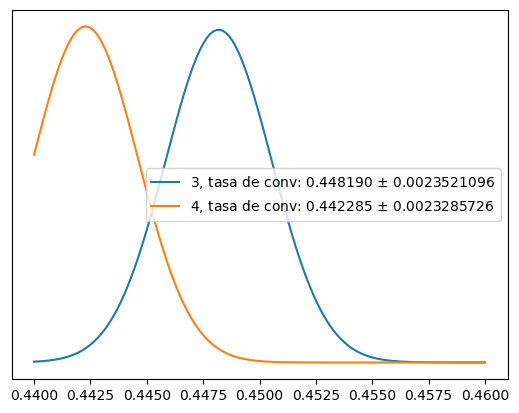

In [149]:
plot(ret1, "34")

In [146]:
salto= (beta_40.mean()- beta_30.mean())/beta_30.mean()
salto*100

-1.3175098158249858

In [147]:
calc_prob(beta_30, beta_40) *100

96.27939748515354

In [150]:
# testeo para retention_7
aa_30, ba_30 = ret307[1]+1, 44700-ret307[1]+1
ab_40, bb_40 = ret407[1]+1, 45489-ret407[1]+1

beta_307 = beta(aa_30, ba_30)
beta_407 = beta(ab_40, bb_40)

print(beta_307.mean(),beta_407.mean())
ret2= beta_307,beta_407

0.19021520289919913 0.18201402475214878


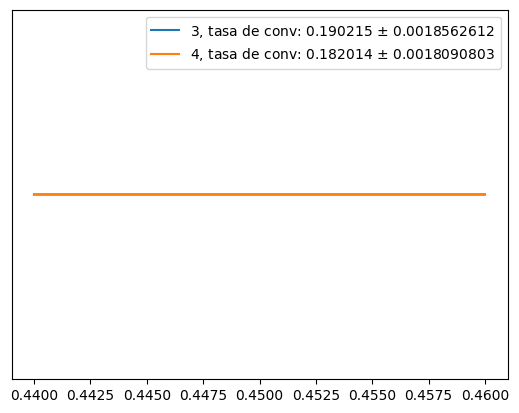

In [155]:
plot(ret2,"34")

In [152]:
salto2 =  (beta_407.mean() - beta_307.mean())/beta_307.mean()
salto2*100

-4.311526114658881

In [153]:
calc_prob(beta_307, beta_407)*100

99.92226613235505

In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.
'''
Fijándonos en la retención a un día tenemos un 96% de probabilidad de que reduzca un 1,3% que la puerta esté en el nivel 30 o en el 40. 

Con respecto a la retención a una semana hay una probabilidad del 99% de que la colocación de la puerta en el nivel 40 frente a ponerla en el
30 reduzca dicha retención en un 4,31%

'''